# About the Dataset

The original CORD-19 is a resource of over 1,000,000 scholarly articles, including over 400,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.

In our project, the dataset is sampled from the CORD-19 with size ~10,000 to reduce computation burden.

In [53]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import abspath, exists

# shared link: https://drive.google.com/drive/folders/1Td_ZTUVrsKeftDE5Zll7252YLJdWiNTk?usp=share_link 
# you can download the data via the shared link, and skip Step 0 and Step 1 if you want to run the code in your local machine 


# Step 0: add the shared folder to your google drive. e.g., /content/drive/MyDrive/CORD_19

# Step 1: Mount Google Drive
#from google.colab import drive
#drive.mount("/content/drive")


#!echo $PWD

#!ls /content/drive/MyDrive/CORD_19/

# Step 2: unzip json files 
subset_dir = os.path.join(os.getcwd(),  "CORD_19_subset")


#zip_file_path="/content/drive/MyDrive/CORD_19/subset.zip"
zip_file_path = abspath("CORD_19/subset.zip")

# Check if the destination directory exists
if not os.path.exists(subset_dir):
    # Unzip the file
    cmd = "unzip {} -d {}".format(zip_file_path, subset_dir)
    proc = subprocess.Popen(cmd, shell=True)
else:
    print(f"Directory {subset_dir} already exists. Skipping extraction.")

Directory /workspaces/COMP5434-Big-Data-Computing/CORD_19_subset already exists. Skipping extraction.


In [54]:
# Import necessary packages
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [55]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Load & Pre-processing

In [56]:
# Load Meta data from meta_10k.csv
data_root = os.path.join(os.getcwd(),'input')

#metadata_path = os.path.join(data_root, 'meta_10k.csv')
metadata_path = abspath("CORD_19/meta_10k.csv")
meta_df = pd.read_csv(metadata_path, index_col=0,converters={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str,
    'doi': str
})

print(len(meta_df))
meta_df.head()

9022


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
44,m71xkuo9,c6bf372c094f035a514975c35a7f9c094abbe493,PMC,Sequence specific visual detection of LAMP rea...,10.1186/1472-6750-6-3,PMC1373654,16401354,cc-by,BACKGROUND: Development of a practical gene po...,2006-01-10,"Mori, Yasuyoshi; Hirano, Tsuyoshi; Notomi, Tsu...",BMC Biotechnol,NaN,NaN,NaN,document_parses/pdf_json/c6bf372c094f035a51497...,document_parses/pmc_json/PMC1373654.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
96,hqc7u9w3,c65f0939cf35a0f04bf93bd6e8f771b8521563a5,PMC,Transmission Parameters of the 2001 Foot and M...,10.1371/journal.pone.0000502,PMC1876810,17551582,cc-by,"Despite intensive ongoing research, key aspect...",2007-06-06,"Chis Ster, Irina; Ferguson, Neil M.",PLoS One,NaN,NaN,NaN,document_parses/pdf_json/c65f0939cf35a0f04bf93...,document_parses/pmc_json/PMC1876810.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN
217,jzwcy7dr,a009c8efa4c5f13a5e604608d4e33e1dac078044,PMC,Results From a Hypothesis Generating Case-Cont...,10.1093/schbul/sbm139,PMC2632504,18156638,bronze-oa,Background: Herpes family viruses can cause ce...,2008-08-20,"Niebuhr, David W.; Millikan, Amy M.; Yolken, R...",Schizophrenia Bulletin,NaN,NaN,NaN,document_parses/pdf_json/a009c8efa4c5f13a5e604...,document_parses/pmc_json/PMC2632504.xml.json,https://academic.oup.com/schizophreniabulletin...,NaN
255,02opdk0m,b411e12b20d883ef2ee5ca19d48eff9fccedf05f,PMC,CVTree update: a newly designed phylogenetic s...,10.1093/nar/gkp278,PMC2703908,19398429,cc-by-nc,The CVTree web server (http://tlife.fudan.edu....,2009-07-01,"Xu, Zhao; Hao, Bailin",Nucleic Acids Res,NaN,NaN,NaN,document_parses/pdf_json/b411e12b20d883ef2ee5c...,document_parses/pmc_json/PMC2703908.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN
342,094d0rn6,513d5ea4db4eb8e94c14c46b018c6041d78119cf,PMC,IPS-1 Is Essential for the Control of West Nil...,10.1371/journal.ppat.1000757,PMC2816698,20140199,cc-by,The innate immune response is essential for co...,2010-02-05,"Suthar, Mehul S.; Ma, Daphne Y.; Thomas, Sunil...",PLoS Pathog,NaN,NaN,NaN,document_parses/pdf_json/513d5ea4db4eb8e94c14c...,document_parses/pmc_json/PMC2816698.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN


In [57]:
# Display the info of the dataframe
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 44 to 1056551
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          9022 non-null   object 
 1   sha               9022 non-null   object 
 2   source_x          9022 non-null   object 
 3   title             9022 non-null   object 
 4   doi               9022 non-null   object 
 5   pmcid             7942 non-null   object 
 6   pubmed_id         9022 non-null   object 
 7   license           9022 non-null   object 
 8   abstract          8289 non-null   object 
 9   publish_time      9022 non-null   object 
 10  authors           9009 non-null   object 
 11  journal           8095 non-null   object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  0 non-null      float64
 14  arxiv_id          480 non-null    object 
 15  pdf_json_files    9022 non-null   object 
 16  pmc_json_files    7414 non-null   object 
 

In [58]:
def glob_files(path, f_type=".json"):
    dst = []
    for root, _, files in os.walk(path):
        for f in files:
            if f.endswith(f_type):
                dst.append(os.path.join(root, f))
    return dst

# glob json files
#json_dir = os.path.join(data_root, "subset","subset","document_parses","pdf_json")
json_dir = abspath("subset/document_parses/pdf_json/")
print(json_dir)
json_files = glob_files(json_dir, ".json")

print("total json files:", len(json_files))

/workspaces/COMP5434-Big-Data-Computing/subset/document_parses/pdf_json
total json files: 12000


In [59]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)

            self.title = content['metadata']['title']

            #dict_keys(['paper_id', 'metadata', 'abstract', 'body_text',
            #'bib_entries', 'ref_entries', 'back_matter'])


    def __repr__(self):
        return f"{self.paper_id}: {self.title } : {self.abstract[:200]}... {self.body_text[:200]}..."


first_row = FileReader(json_files[0])
print(first_row)

66212b08ea1215275947f3bb43d49ac4c607a4a2: Patients With Lower Limb Deformity Report Worse Quality of Life Than Control Subjects Regardless of Degree of Deformity : Introduction: The purpose of this study was to determine how Limb Deformity Modified Scoliosis Research Society (LD-SRS) scores differ between patients with different types and degrees of limb deformi... stature also report worse mental health and selfimage. 5, 6, 8 One study by Montpetit et al 8 found that adolescent patients with lower limb deformities reported markedly lower scores in physical heal...


In [60]:
from tqdm import tqdm

def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data


dict_ = {'paper_id': [], 'publish_time': [], 'doi':[], 'abstract': [], 'body_text': [],
         'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}


for idx, entry in tqdm(enumerate(json_files), total=len(json_files)):
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip

    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0:
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)

    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]

    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])

    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])

    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])

    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])

    # add publish time
    publish_time = meta_data['publish_time'].values[0]
    if len(publish_time) > 4:
        publish_time = datetime.strptime(publish_time, '%Y-%m-%d') 
    elif len(publish_time) == 4:
        publish_time += '-01-01'
        publish_time = datetime.strptime(publish_time, '%Y-%m-%d')
        
    dict_['publish_time'].append(publish_time)

df_covid = pd.DataFrame(dict_, columns=['paper_id', 'publish_time', 'doi', 'abstract', 'body_text',
                                        'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [01:51<00:00, 107.21it/s]


,paper_id,publish_time,doi,abstract,body_text,authors,title,journal,abstract_summary
0,66212b08ea1215275947f3bb43d49ac4c607a4a2,2021-08-10,10.5435/jaaosglobal-d-21-00182,Introduction: The purpose of this study was to...,stature also report worse mental health and se...,"Heath, Madison R.. Shin, Tom J.. Mehta, Ren...",Patients With Lower Limb Deformity Report<br>...,J Am Acad Orthop Surg Glob Res Rev,Introduction: The purpose of this study was t...
1,f5ee90d8bfc237f0523512eeb8b22c3f2d735602,2021-08-29,10.3390/curroncol28050290,,Bone metastases are a common complication of c...,"Tsukamoto, Shinji. Kido, Akira. Tanaka,<br>...",Current Overview of Treatment for Metastatic<...,Curr Oncol,Not provided.
2,6c610086f052937db3e36184af6a7175e96c5443,2022-04-21,10.1080/10872981.2022.2068210,Introduction: An evidence gap exists identifyi...,Developing practical skill competency is a sig...,"Forde, Cuisle. OBrien, Annie",A Literature Review of Barriers and<br>Opport...,Med Educ Online,Introduction: An evidence gap exists<br>ident...
3,3b34988f886b06469b86cc828ed5ad9a591fbf5e,2022-01-08,10.1007/s11277-022-09463-x,Corona Virus continues to harms its effects on...,COVID-19 is an infectious and fast spreading d...,"Thirukrishna, J. T.. Krishna, Sanda Reddy Sa...",Survey on Diagnosing CORONA VIRUS from<br>Rad...,Wirel Pers Commun,Corona Virus continues to harms its effects o...
4,2dcb2c53f12e45bb92c07e5b47d82dbe495bede9,2017-09-04,10.1186/s12913-017-2552-1,Background: Hospital usage and service demand ...,"Increase in trade and travel, as well as ecolo...","Singh, Shweta R.. Coker, Richard. Vrijhoef,...",Mapping infectious disease hospital surge<br>...,BMC Health Serv Res,Background: Hospital usage and service demand...


In [61]:
# Display the info of the dataframe
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9022 entries, 0 to 9021
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          9022 non-null   object        
 1   publish_time      9022 non-null   datetime64[ns]
 2   doi               9022 non-null   object        
 3   abstract          9022 non-null   object        
 4   body_text         9022 non-null   object        
 5   authors           9009 non-null   object        
 6   title             9022 non-null   object        
 7   journal           8095 non-null   object        
 8   abstract_summary  9022 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 634.5+ KB


In [62]:
# Drop NaN values
df = df_covid
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8083 entries, 0 to 9021
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          8083 non-null   object        
 1   publish_time      8083 non-null   datetime64[ns]
 2   doi               8083 non-null   object        
 3   abstract          8083 non-null   object        
 4   body_text         8083 non-null   object        
 5   authors           8083 non-null   object        
 6   title             8083 non-null   object        
 7   journal           8083 non-null   object        
 8   abstract_summary  8083 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 631.5+ KB


In [63]:
# Text cleaning function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalnum() and word.lower() not in stop_words]
    return ' '.join(words)

# Apply text cleaning to abstract and body_text
df['abstract'] = df['abstract'].apply(clean_text)
df['body_text'] = df['body_text'].apply(clean_text)

In [64]:
!pip install langdetect

In [65]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:

            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass

    # get the language
    languages.append(lang)

  0%|          | 0/8083 [00:00<?, ?it/s]

100%|██████████| 8083/8083 [00:50<00:00, 160.81it/s]


In [66]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 8083

{'de': 20, 'en': 8030, 'es': 15, 'fr': 15, 'it': 1, 'nl': 2}


In [67]:
df['language'] = languages
df = df[df['language'] == 'en']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8030 entries, 0 to 9021
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          8030 non-null   object        
 1   publish_time      8030 non-null   datetime64[ns]
 2   doi               8030 non-null   object        
 3   abstract          8030 non-null   object        
 4   body_text         8030 non-null   object        
 5   authors           8030 non-null   object        
 6   title             8030 non-null   object        
 7   journal           8030 non-null   object        
 8   abstract_summary  8030 non-null   object        
 9   language          8030 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 690.1+ KB


# Histogram of year / journal

In [68]:
#keep 2010 later
df = df[df['publish_time'].dt.year >= 2010]
df['publish_year'] = df['publish_time'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7739 entries, 0 to 9021
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          7739 non-null   object        
 1   publish_time      7739 non-null   datetime64[ns]
 2   doi               7739 non-null   object        
 3   abstract          7739 non-null   object        
 4   body_text         7739 non-null   object        
 5   authors           7739 non-null   object        
 6   title             7739 non-null   object        
 7   journal           7739 non-null   object        
 8   abstract_summary  7739 non-null   object        
 9   language          7739 non-null   object        
 10  publish_year      7739 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(9)
memory usage: 695.3+ KB


[Text(0, 0, '60'),
 Text(0, 0, '66'),
 Text(0, 0, '70'),
 Text(0, 0, '76'),
 Text(0, 0, '74'),
 Text(0, 0, '79'),
 Text(0, 0, '100'),
 Text(0, 0, '97'),
 Text(0, 0, '100'),
 Text(0, 0, '140'),
 Text(0, 0, '2068'),
 Text(0, 0, '3535'),
 Text(0, 0, '1274')]

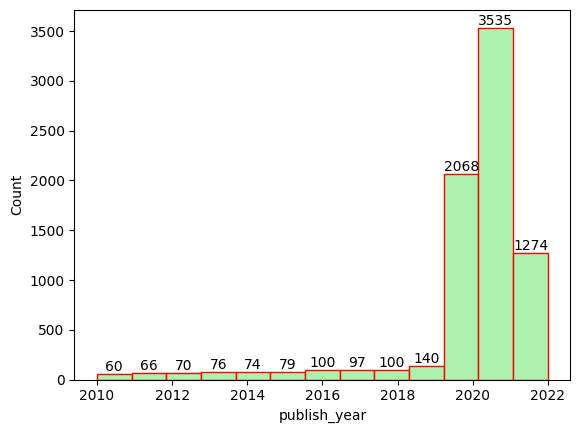

In [69]:
import seaborn as sns

ax = sns.histplot(df["publish_year"], color='lightgreen', edgecolor='red', bins=13) 
ax.bar_label(ax.containers[0])


# Histogram of Journal

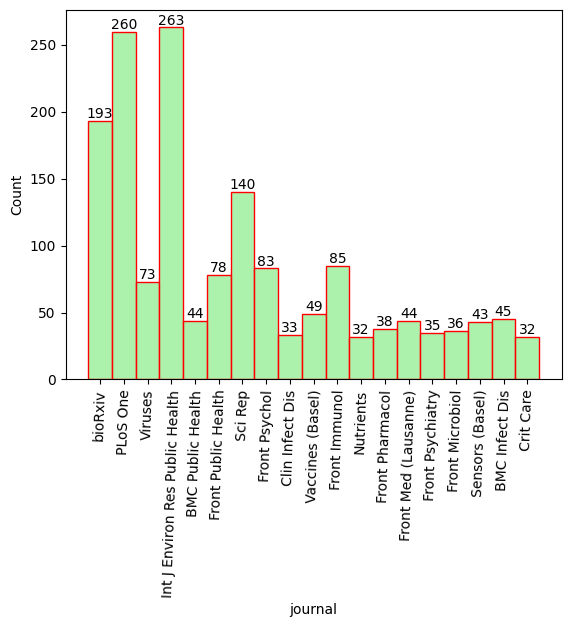

In [70]:
a = df.groupby('journal').filter(lambda x: len(x) > 30)
bx = sns.histplot(a['journal'], color='lightgreen', edgecolor='red') 
bx.bar_label(bx.containers[0])
bx.tick_params(axis='x', rotation=88)

# Remove Stop Word

In [71]:
#NLP
import spacy
import string
from spacy.lang.en import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[0:10]

custom_stop_words = [
    'doi','preprint','copyright','peer','reviewed','org','https','et','al','author','figure',
    'rights','reserved','permission','used','using','biorxiv','medrxiv','license','fig','fig.',
    'al.','Elsevier','PMC','CZI', 'are', 'their', 'be',
    'a', 'after', 'also', 'an', 'and', 'as', 'at', 'base', 'between', 'but', 'by', 'did', 'do', 'does', 'during', 'for', 'from', 
    'have', 'has', 'had', 'however',
    'in', 'is', 'it', 'its', 'new', 'of', 'on', 'or', 
    'that', 'the', 'to', 'use', 'using', 'was', 'we', 'were', 'which', 'with', '=', 'br',
    'SARS-CoV-2'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

# Parser
#parser = en_core_sci_lg.load(disable=["tagger","ner"])
#nlp = spacy.load('en_core_web_sm',disable=["tagger","ner"])
nlp = spacy.load('en_core_web_sm',disable=["tagger","parser","ner"]) # Only tokenization and lemmation are performed, POS tagging, NER and syntactic parsing are skipped.
nlp.max_length = 7000000

stopwords = set(stopwords)
punctuations = set(punctuations)
print('len(stopwords):',len(stopwords),'len(punctuations):',len(punctuations), 'typeof(stopwords):', type(stopwords))

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma != '-PORN-' else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    mytokens = [word for word in mytokens if word.isalpha() and len(word) > 2 and word in nlp.vocab]
    #mytokens = [word for word in mytokens if detect(word) == 'en']
    mytokens = " ".join([i for i in mytokens])
    return mytokens

tqdm.pandas()
df['procesed_text'] = df['body_text'].progress_apply(spacy_tokenizer)
df['procesed_abstract'] = df['abstract'].progress_apply(spacy_tokenizer)
df['procesed_title'] = df['title'].progress_apply(spacy_tokenizer)
df.head()

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

# Map-Reduce 

In [ ]:
import csv
import re
from collections import defaultdict
from functools import reduce

# Sample data: list of documents (each document is a string)
documents_MR = []
with open(metadata_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        documents_MR.append(row[4])  # Assuming the 4th column is at index 3 (0-based indexing)
        documents_MR.append(row[9])  # Assuming the 9th column is at index 4 (0-based indexing)


# Specify the words to include in the stoplist
stop_words_upper = ["A", "After", "All", "Also", "An", "And", "Are", "As", "At", "Base", "Be", "Been", "Between", "But", "By", "Can", "Did", "Do", "Does", "During", "For", "From", "Have", "Has", "Had", "However",
                    "In", "Into", "Is", "It", "Its", "New", "Not", "Of", "On", "Or", "Our", "Than", "That", "The", "Their", "There", "These", "This", "To", "Use", "Used", "Using", "Was", "We", "Were", "Which", "Who", "With", "="]
stop_words_lower = [word.lower() for word in stop_words_upper]

# Mapper function
def map_function(documents_MR):
    # Split the document into words and assign an ID to each word
    for idx, word in enumerate(documents_MR.split(), start=1):
      yield (word.lower(), 1)

# Step 1: Map phase
mapped = []
for documents_MR in documents_MR:
    mapped.extend(map_function(documents_MR))

# Step 2: Shuffle and sort phase (group by key)
shuffled = defaultdict(list)
for word, count in mapped:
    shuffled[word].append(count)

# Step 3: Reduce phase
reduced = {}
for word, counts in shuffled.items():
    reduced[word] = reduce(lambda x, y: x + y, counts)

# Step 4: Merge the counts of words with uppercase and lowercase versions together
merged_counts = defaultdict(int)
for word, count in reduced.items():
    merged_word = re.sub(r'[^a-zA-Z0-9]', '', word)
    # Remove non-alphanumeric characters
    merged_counts[merged_word.lower()] += count

# Step 5.1: filter out the stop words
filtered = {word: count for word, count in reduced.items() if word not in stop_words_upper and word not in stop_words_lower}

# Step 5.2: Sort the filtered words by count in descending order
sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
sorted_words_unfilter = sorted(reduced.items(), key=lambda x: x[1], reverse=True)

# Step 5.3: Get the top 50 prevalent words
top50_filtered = sorted_words[:50]
top50_unfilter = sorted_words_unfilter[:80]


# Step 6.1: Print the table of the top 50 prevalent words without stop words list
print("Top 80 Prevalent Words without stopwords:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top50_unfilter, start=1):
    print(f"{idx:<4}{word:<20}{count}")
print("\n"+"\n")

# Step 6.2: Print the table of the top 50 prevalent words with IDs
print("Top 50 Prevalent Words:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top50_filtered, start=1):
    print(f"{idx:<4}{word:<20}{count}")


Top 80 Prevalent Words without stopwords:
ID  Word                Count
-----------------------------
1   the                 97935
2   of                  75152
3   and                 71142
4   in                  46376
5   to                  40334
6   a                   30698
7   with                20595
8   for                 19646
9   is                  12786
10  were                12217
11  that                11841
12  on                  11311
13  was                 11006
14  covid-19            10343
15  this                10102
16  as                  10067
17  we                  9942
18  by                  9331
19  from                8221
20  are                 7789
21  patients            7203
22  an                  7006
23  be                  6202
24  study               5251
25  or                  5157
26  at                  5110
27  have                4582
28  during              4384
29  health              4244
30  has                 4039
31  these   

# Association Analysis

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import gensim.downloader as api

def get_target_document_index(X,token_list,target_word_list,model_name='glove-wiki-gigaword-100',top_feature=20,top_document=100):
    
    '''
    Compare each target word to all token used as feature and find the top related document index.
    Using gensim model for semantic analysis by default using glove-wiki-gigaword-100.
    Return a dictionary of most related documents index for each target word.
    
    Argument:
    
    - X:
    A numpy array of characteristic matrix with row as number of feature and column as number of document. 
    Recommend to use the token count as feature.
    
    - token_list:
    A list of string that use to build the feature of the characteristic matrix.
    
    - target_word_list:
    A list of string that all token compare with.
    Each target word can be any string that is not in the token_list but must be in the model.
    
    - model_name:
    A string of model name that use to give a similarity of score between the target worad and the token used.
    Must be a valid model name that can be called by using Gensim API.
    
    - top_feature:
    An integer number of most related features compare with the target word.
    
    - top_document:
    An integer number of most related documents compare with the target word.
    '''
    
    print(f'Using Model: {model_name}\n')
    
    model = api.load(model_name)
    
    # Check all target words are in the model
    for target_word in target_word_list:
        if target_word not in model:
            ValueError(f'Argument: target_word is not in model {model_name}')
            
    # Check input top_feature and token_list size
    if len(token_list) <= top_feature:
        print(f'Warning: Argument top_feature ({top_feature}) is greater than or equal to token_list size ({len(token_list)})')
        print('No feature filtering will be performed.\n')
        
    # Check the proportion of token that is not in model.
    token_not_exist = 0
    for i in token_list:
        if i not in model:
            token_not_exist += 1
            
    print(f'Token not in model: {token_not_exist}/{len(token_list)} ({round(token_not_exist/(len(token_list))*100,1)}%)')
    

    # Create a result dictionary for all target words
    
    result_dict = {}
    for i in range(0,len(target_word_list)):
        
        target_word = target_word_list[i]
        print(f'Comparing target word {i}/{len(target_word_list)}: {target_word}')
        
        token_score_df = get_target_word_similarity(model,token_list,target_word)
        doc_to_keep = get_most_similar_document(X,token_score_df,token_list,top_feature=top_feature,top_document=top_document)
        result_dict[target_word] = doc_to_keep
        
    return result_dict

        
def get_target_word_similarity(model,token_list,target_word):
    '''
    Return the similarity score for all tokens used as feature compare with the target word.
    Using cosine similarity by default.
    '''
    
    target_word_feature = model[target_word]
    target_word_norm = np.linalg.norm(target_word_feature)
    
    # List of tokne used to build feature
    # token_list = list(vectorizer.get_feature_names_out())
    
    token_score_list = []
    
    # token_exist = 0
    # token_not_exist = 0
    
    # Use cosine similarity between the target word and the token using feature created from gensim model.
    for token in token_list:
        if token in model:
            token_norm = np.linalg.norm(model[token])
            score = (model[token] @ target_word_feature.T)/(token_norm*target_word_norm)
            # token_exist += 1
        else:
            score = None
            # token_not_exist += 1
            
        token_score_list.append(score)

    # print(f'Number of token exists in model:{token_exist}/{token_exist+token_not_exist} ({round(token_exist/(token_exist+token_not_exist)*100,1)}%)')

    df = pd.DataFrame({'token':token_list,'score':token_score_list})
    df = df.sort_values(by=['score'],ascending=False)
    df = df.fillna(0)
    
    return df

    
def get_most_similar_document(X,token_score_df,token_list,top_feature=20,top_document=100):
    
    '''
    - X:
    A 2D numpy array characteristic matrix with number of token as row, number of document as column.
    Prefer using count of token occurrence as feature.
    
    - token_score_df:
    A pandas dataframe with the similarity score for each token compare with the target word.
    
    - top_feature:
    An integer number of most related features compare with the target word.
    
    - top_document:
    An integer number of most related documents compare with the target word.
    
    Return a list of document number with zero based index.
    The list is truncated by the size of top_document.
    The document index is in the descending order of similarity score followed by the document index in the characteristic matrix.
    '''
    
    keep_feature = list(token_score_df.head(top_feature)['token'])
    
    # Loop through all token in characteristic matrix to find the feature to keep
    token_index_list = []
    for i in range(0,len(token_list)):
        if token_list[i] in keep_feature:
            token_index_list.append(i)
            
    # Filter to only contain the most related features
    X_modify = X[token_index_list,:]
    
    # Sum all remaining feature values to create a score for each document
    doc_score = np.sum(X_modify,axis=0)
    doc_rank = ss.rankdata(doc_score,method='min')
    
    distinct_rank = list(set(doc_rank))
    distinct_rank.sort()
    
    doc_to_keep = []

    # When multiple documents have the same rank, it may exceed the number of top document limit.
    # Put the document with the lowest rank into the list first.
    # Cap the list size with the number of top document limit.
    for j in distinct_rank:

        for i in range(0,len(doc_rank)):
            rank = doc_rank[i]

            if rank == j and len(doc_to_keep) < top_document:
                doc_to_keep.append(i)
                if len(doc_to_keep) >= top_document:
                    break

    return doc_to_keep

ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/codespace/.local/lib/python3.10/site-packages/scipy/linalg/__init__.py)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

feature_size = 2**12
count_vectorizer = CountVectorizer(max_features=feature_size)
X_count = count_vectorizer.fit_transform(df['procesed_text'].values).toarray().T

KeyError: 'procesed_text'

In [ ]:
target_word_list = ['vaccination', 'good', 'result'] # not in feature but in model

if len(target_word_list) > 0:
    token_list = list(count_vectorizer.get_feature_names_out())
    index_dict = get_target_document_index(X_count,token_list,target_word_list)
    interested_list = list()
    for key in index_dict:
        interested_list += index_dict[key]

    df = df.iloc[interested_list]

In [ ]:
df['procesed_title_list'] = df['procesed_title'].str.split()
df['procesed_title_list']

In [ ]:
df['procesed_text_list'] = df['procesed_text'].str.split()
df['procesed_text_list']

In [ ]:

df['procesed_abstract_list'] = df['procesed_abstract'].str.split()
df['procesed_abstract_list']


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules 
from mlxtend.preprocessing import TransactionEncoder

# Pre-processing
te = TransactionEncoder()
te_ary = te.fit (df['procesed_text_list']).transform(df['procesed_text_list'])
df_processd_text = pd.DataFrame (te_ary, columns=te.columns_)
print(df_processd_text)

In [ ]:
# Building the model 
frq_items = apriori(df_processd_text, min_support = 0.2, use_colnames = True) 
frq_items

In [ ]:
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="confidence", min_threshold = 0.95)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x)) 
rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x)) 
rules = rules.sort_values(['antecedent_len', 'consequents_len', 'confidence', 'lift'], ascending=[False, False, False, False]) 
#print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(100)) 
print(rules[['antecedents', 'consequents']]) 

# Association Rule (LDA)

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Create Dictionary
id2word = corpora.Dictionary(df['procesed_abstract_list'])
# Create Corpus
texts = df['procesed_abstract_list']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Set number of topics
num_topics = 10
# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha='auto', per_word_topics=True)
# Print the keywords for each topic
pprint(lda_model.print_topics())
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['procesed_abstract_list'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/codespace/.local/lib/python3.10/site-packages/scipy/linalg/__init__.py)

# Similarity Analysis

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy.stats import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hashlib

from matplotlib import pyplot as plt
# from datasketch import MinHash, Simhash
import utils
from similarity_analysis import *

import warnings
warnings.filterwarnings('ignore')

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/codespace/.local/lib/python3.10/site-packages/scipy/linalg/__init__.py)

In [72]:
# pick a target document to compare
target_doc_num = 0

# input feature size (number of token used)
feature_size = 2**12
random.seed(10)

# input folder
data_root = os.path.join(os.getcwd(),'input')

In [73]:
df = utils.load_data_from_local(data_root)

NameError: name 'utils' is not defined

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy.stats import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hashlib

from matplotlib import pyplot as plt
# from datasketch import MinHash, Simhash
import utils

import warnings
warnings.filterwarnings('ignore')


def check_document_similarity(X,df,target_doc_num):
    '''
    Given the target document number, return the similarity to other documents.
    Output is a pandas dataframe with number of document as number of row.
    '''
    
    target_doc = X.T[target_doc_num]
    target_doc_norm = np.linalg.norm(target_doc)
    
    doc_l2_norm_list = []
    doc_l1_norm_list = []
    doc_cosine_list = []
    
    # Similarity from characteristic matrix X
    # X is 4096(feature) x 8041(document)
    
    for doc in X.T:
        doc_norm = np.linalg.norm(doc)
        doc_l2_norm = np.linalg.norm(target_doc - doc)
        doc_l1_norm = np.linalg.norm(target_doc - doc,ord=1)
        doc_cosine = doc@target_doc.T/(doc_norm*target_doc_norm)

        doc_l2_norm_list.append(doc_l2_norm)
        doc_l1_norm_list.append(doc_l1_norm)
        doc_cosine_list.append(doc_cosine)

    
    result = pd.DataFrame(
        {
            'doc_l1_norm':doc_l1_norm_list,
            'doc_l2_norm':doc_l2_norm_list,
            'doc_cosine_similarity':doc_cosine_list,
            # 'sig_cosine_similarity':sig_cosine_list,
            # 'sig_jaccard_similarity':sig_jaccard_list
        }
    )
    
    result = result.reset_index().rename(columns={'index':'doc_num'})
    result = pd.concat([result,df[['paper_id','body_text']]],axis=1)
    
    return result

def get_permutate_matrix(X,num_perm=50):
    
    '''
    Return premutation matrix with size:
    number of feature x number of permutation
    '''
    
    N = len(X) # number of features

    p = []

    for i in range(0,num_perm):
        a = random.randint(0, N-1)
        b = random.randint(0, N-1)
        
        new_order = np.array([])
        not_used = list(range(1,N+1))
        
        for j in range(0,N):
            # Buckets are set to be 1 to N
            hash_value = (a*j+b)%N+1
            
            # When 2 hashes mapped to the same bucket, the second hash move to the next bucket.
            while hash_value not in not_used:
                hash_value += 1
                if hash_value > N:
                    hash_value = 1

            not_used.remove(hash_value)
            new_order = np.append(new_order,hash_value)
              
        p.append(new_order)
        
    p = np.array(p).T
    
    return p

def get_minhash_signature(X,p):
    '''
    Return signature matrix with size: number of permutation x number of document
    '''

    s = []
    
    # X is 4096(feature) x 8041(document)
    # p is 4096(feature) x 50 (permutation)
    # Create a signature matrix with size as number of permutation x number of document

    for perm in p.T:
        doc_sig = np.array([])
        for doc in X.T:
            sig_set = set(np.multiply(doc,perm))
            sig_set.discard(0)
            sig = min(sig_set)
            doc_sig = np.append(doc_sig,sig)
            
        s.append(doc_sig)

    s = np.array(s)
    
    return s

def check_minhash_similarity(s,target_doc_num):

    sig_jaccard_list = []
    sig_cosine_list = []
    
    # Similarity from signature matrix
    # s is 50(permutation) x 8041(document)
    
    target_sig = s.T[target_doc_num]
    target_sig_norm = np.linalg.norm(target_sig)
    
    # loop through all document to create a list of score
    for sig in s.T:
        sig_norm = np.linalg.norm(sig)
        sig_cosine = (sig @ target_sig.T)/(sig_norm*target_sig_norm)
        sig_cosine_list.append(sig_cosine)

        sig_intersection = len(list(set(target_sig).intersection(sig)))
        sig_union = (len(set(target_sig)) + len(set(sig))) - sig_intersection
        sig_jaccard = sig_intersection / sig_union
        sig_jaccard_list.append(sig_jaccard)   
        
    df = pd.DataFrame(
        {
            'sig_cosine_similarity':sig_cosine_list,
            'sig_jaccard_similarity':sig_jaccard_list
        }
    )
    
    df = df.reset_index().rename(columns={'index':'doc_num'})
    
    return df


def get_feature_hash(feature_list):
        
    feature_hash = []
    max_bit_size = 0
    
    for feature_name in feature_list:        
        # Use MD5 or SHA1 to encode, since these hash functions are localicity sensitive
        # Convert the integer into string of 0 or 1 as a hash.
        
        encod_feature = str.encode(feature_name)
        
        # MD5
        feature_byte = hashlib.md5(encod_feature).digest()
        feature_int = int.from_bytes(feature_byte, byteorder='little')
        
        # SHA1
        # feature_byte = hashlib.sha1(encod_feature).hexdigest()
        # feature_int = int(feature_byte, 16)
        
        feature_bit = f'{feature_int:0b}'
        feature_hash.append(feature_bit)
        
        bit_size = feature_int.bit_length()
        
        if bit_size > max_bit_size:
            max_bit_size = bit_size
        
    for i in range(0,len(feature_hash)):
        feature_hash[i] = feature_hash[i].zfill(max_bit_size)
        
    return feature_hash


def get_doc_finger_print(feature_hash,doc):
    finger_print = ''
    total_bit = len(feature_hash[0])
    
    # Loop through each bit in hash
    for bit_pos in range(0,total_bit):
        bit_weight = 0
        
        # Loop through all feature
        for i in range(0,len(doc)):
            feature_value = doc[i]
            hash = feature_hash[i] # hash of the ith feature
            bit = hash[bit_pos]
            
            if bit == '1':
                bit_weight += feature_value
            elif bit == '0':
                bit_weight -= feature_value
            else:
                ValueError(f'Invalid bit value: {bit} at position {bit_pos} in document {i}')
        
        # Determine the finger print bit by the bit_weight
        if bit_weight > 0:
            finger_print_bit = '1'
        elif bit_weight < 0:
            finger_print_bit = '0'
        # When the bit has same number of feature as 1 and 0, use the bit position to determine the finger print bit.
        else:
            finger_print_bit = str(bit_pos%2)
        
        finger_print += finger_print_bit
        
    return finger_print


def get_finger_print_list(X,feature_hash):
    
    finger_print_list = []
    
    for doc in X.T:
        finger_print = get_doc_finger_print(feature_hash,doc)
        finger_print_list.append(finger_print)
    
    return finger_print_list


def check_simhash_similarity(finger_print_list,target_doc_num):
    
    # sig_cosine_list = []
    sig_hamming_distance_list = []
    
    target_sig = finger_print_list[target_doc_num]
    # target_sig_norm = np.linalg.norm(target_sig)
    
    for sig in finger_print_list:
        # sig_norm = np.linalg.norm(sig)
        # sig_cosine = (sig @ target_sig.T)/(sig_norm*target_sig_norm)
        # sig_cosine_list.append(sig_cosine)
        
        # Distance is the number of different bit
        sig_hamming_distance = 0
        
        for i in range(0,len(sig)):
            if sig[i] != target_sig[i]:
                sig_hamming_distance += 1
        
        sig_hamming_distance_list.append(sig_hamming_distance)
    
    df = pd.DataFrame(
        {
            # 'sig_cosine_similarity':sig_cosine_list,
            'sig_hamming_distance':sig_hamming_distance_list
        }
    )
    
    df = df.reset_index().rename(columns={'index':'doc_num'})
    
    return df


def tag_documents(tokenizer,orginal_docs):
    tagged_docs = []
    for i in range(0,len(orginal_docs)):
        doc = orginal_docs[i]
        doc_id = str(i)
        tokens = tokenizer.tokenize(doc)
        tagged_doc = TaggedDocument(words=tokens,tags=[doc_id])
        tagged_docs.append(tagged_doc)
        
    return tagged_docs


def get_doc2vec_result(model,tokenizer,original_docs,target_doc_num):
    
    target_doc = original_docs[target_doc_num]
    target_tokens = tokenizer.tokenize(target_doc)
    inferred_vector = model.infer_vector(target_tokens)
    similar_docs = model.dv.most_similar([inferred_vector],topn=len(original_docs))
    
        
    doc_num_list = []
    rank_list = []

    for i in range(0,len(similar_docs)):
        doc = similar_docs[i]
        # rank start from 1 instead of 0, 1 has highest similarity
        rank = i + 1
        doc_num = int(doc[0])
        
        rank_list.append(rank)
        doc_num_list.append(doc_num)
        
    doc2vec_result = pd.DataFrame({'doc2vec':rank_list,'doc_num':doc_num_list})
    
    return doc2vec_result


def get_performance_rank(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result):

    # Create ranking of similarity from previous result, similar item has the lowest rank

    # Rank from directly comparing the document features
    tfidf_rank = tfidf_result[['doc_num','doc_cosine_similarity']]
    tfidf_rank['tfidf_doc_cosine'] = tfidf_rank['doc_cosine_similarity'].rank(ascending=False)
    # tfidf_rank['tfidf_doc_l1_norm'] = tfidf_rank['doc_l1_norm'].rank(ascending=True)
    # tfidf_rank['tfidf_doc_l2_norm'] = tfidf_rank['doc_l2_norm'].rank(ascending=True)
    performance_df = tfidf_rank[['doc_num','tfidf_doc_cosine']]

    count_rank = count_result[['doc_num','doc_cosine_similarity']]
    count_rank['count_doc_cosine'] = count_rank['doc_cosine_similarity'].rank(ascending=False)
    # count_rank['count_doc_l1_norm'] = count_rank['doc_l1_norm'].rank(ascending=True)
    # count_rank['count_doc_l2_norm'] = count_rank['doc_l2_norm'].rank(ascending=True)
    performance_df = performance_df.merge(count_rank[['doc_num','count_doc_cosine']],how='outer',on='doc_num')

    clip_rank = clip_result[['doc_num','doc_l1_norm']]
    # clip_rank['clip_doc_cosine'] = clip_rank['doc_cosine_similarity'].rank(ascending=False)
    clip_rank['clip_doc_l1_norm'] = clip_rank['doc_l1_norm'].rank(ascending=True)
    # clip_rank['clip_doc_l2_norm'] = clip_rank['doc_l2_norm'].rank(ascending=True)
    performance_df = performance_df.merge(clip_rank[['doc_num','clip_doc_l1_norm']],how='outer',on='doc_num')


    # Rank from comparing the document features
    minhash_rank = minhash_result[['doc_num','sig_cosine_similarity','sig_jaccard_similarity']]
    # minhash_rank['minhash_cosine'] = minhash_rank['sig_cosine_similarity'].rank(ascending=False)
    minhash_rank['minhash_jaccard'] = minhash_rank['sig_jaccard_similarity'].rank(ascending=False)
    performance_df = performance_df.merge(minhash_rank[['doc_num','minhash_jaccard']],how='outer',on='doc_num')

    simhash_rank = simhash_result[['doc_num','sig_hamming_distance']]
    simhash_rank['simhash_hamming'] = simhash_rank['sig_hamming_distance'].rank(ascending=True)
    performance_df = performance_df.merge(simhash_rank[['doc_num','simhash_hamming']],how='outer',on='doc_num')
    
    return performance_df


def get_performance_rank_diff(df,benchmark='tfidf_doc_cosine'):
    '''
    Compare the performance with the benchmark field.
    By default it is the cosine similarity of document TF-IDF.
    '''
            
    for col in df:
        if col not in ['doc_num',benchmark]:
            df[col] = df[col] - df[benchmark]
    
    return df

In [74]:
# Build feature with token count
count_vectorizer = CountVectorizer(max_features=feature_size)
X_count = count_vectorizer.fit_transform(df['processed_text'].values).toarray().T

# Clip count between 0 and 1 to only consider the token exists in document or not
X_clip = np.clip(X_count, 0, 1)

# Use TF-IDF as feature to only consider interseting words
tfidf_vectorizer = TfidfVectorizer(max_features=feature_size)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'].values).toarray().T

KeyError: 'processed_text'

In [75]:
count_result = check_document_similarity(X_count,df,target_doc_num)
clip_result = check_document_similarity(X_clip,df,target_doc_num)
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)

NameError: name 'check_document_similarity' is not defined

MinHash

Using token occurrence as document feature. Create a signature matrix using MinHash.
Compare the signature Jaccard similarity with the document L1 Norm (Hamming distance).

In [78]:
def minhash_with_different_permutation(X_clip,clip_result,target_doc_num,num_perm_list):
    
    '''
    The only parameter to fine tune in MinHash is the number of permutation used to generate the signature matrix.
    '''
    
    permutation_dict = {}
    
    clip_result = check_document_similarity(X_clip,df,target_doc_num)
    
    for num_perm in num_perm_list:
        p = get_permutate_matrix(X_clip,num_perm=num_perm)
        s = get_minhash_signature(X_clip,p)
        
        minhash_result = check_minhash_similarity(s,target_doc_num)
        minhash_result = clip_result.merge(minhash_result,how='outer',on='doc_num')
        minhash_result = minhash_result.sort_values(by=['sig_jaccard_similarity'],ascending=False)
        
        permutation_dict[num_perm] = minhash_result
    
    return permutation_dict


def compare_minhash_fine_tune(permutation_dict):
    
    '''
    The performance of MinHash is defined by how the signature matrix gives a 
    close similarity score compare with the characteristic matrix.
    In the other words, documents have a high similarity score to a target 
    document will have a close similarity score when using the signature matrix.
    The relation between the characteristic matrix similarity and the signature 
    matrix similarity can be expressed as the correlation between the characteristic 
    matrix cosine similarity and the signature matrix Jaccard similarity.
    Therefore, a higher Pearson correlation implies a better performance in 
    dimension reduction while maintaining the data pattern in the characteristic matrix.
    '''
    
    num_perm_list = []
    correlation_list = []
    pvalue_list = []
    
    for num_perm in permutation_dict:
        
        minhash_result = permutation_dict[num_perm]
        correlation, pvalue = pearsonr(minhash_result['sig_jaccard_similarity'],minhash_result['doc_l1_norm'])
        
        num_perm_list.append(num_perm)
        correlation_list.append(correlation)
        pvalue_list.append(pvalue)
        
    df = pd.DataFrame({
        'num_perm':num_perm_list,
        'correlation':correlation_list,
        'pvalue':pvalue_list
    })
    
    df = df.sort_values(by=['num_perm'],ascending=False)
    
    return df
        

In [79]:
# Input to test the minhash performance
num_perm_list = list(range(40,130,10))

In [80]:
permutation_dict = minhash_with_different_permutation(X_clip,clip_result,target_doc_num,num_perm_list)
minhash_fine_turn_result = compare_minhash_fine_tune(permutation_dict)
minhash_fine_turn_result

NameError: name 'X_clip' is not defined

In [ ]:
optimal_perm_num = minhash_fine_turn_result['correlation'].max()
minhash_result = permutation_dict[optimal_perm_num]
minhash_result.plot(x='sig_jaccard_similarity', y='doc_cosine_similarity', style='o')

SimHash

Using TF-IDF as document feature. Create a signature matrix using SimHash.
Compare the signature Hamming distance with the document cosine similarity.

In [ ]:
tfidf_feature_list = list(tfidf_vectorizer.get_feature_names_out())
feature_hash = get_feature_hash(tfidf_feature_list)
finger_print_list = get_finger_print_list(X_tfidf,feature_hash)

In [ ]:
# Check Performance
tfidf_result = check_document_similarity(X_tfidf,df,target_doc_num)
simhash_result = check_simhash_similarity(finger_print_list,target_doc_num)

simhash_result = tfidf_result.merge(simhash_result,how='outer',on='doc_num')
simhash_result = simhash_result.sort_values(by=['sig_hamming_distance'],ascending=True)

In [ ]:
print(pearsonr(simhash_result['doc_cosine_similarity'],simhash_result['sig_hamming_distance']))
simhash_result.plot(x='doc_cosine_similarity', y='sig_hamming_distance', style='o')

Doc2Vec

Word2Vec also need to consider token position for word embeding. Use the original text instead of the processed text for vectorization.

In [ ]:
# Use pretrained model to tokenize the documents.
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [77]:
# Use abstract summsry since it has less tokens.
original_docs = list(df['abstract_summary'])
tagged_docs = tag_documents(tokenizer,original_docs)

NameError: name 'tag_documents' is not defined

In [ ]:
model = Doc2Vec()
model.build_vocab(tagged_docs)
model.train(tagged_docs,total_examples=model.corpus_count,epochs=20)

doc2vec_result = get_doc2vec_result(model,tokenizer,original_docs,target_doc_num)
doc2vec_result

Comparing the performance of different document similarity search methods with the cosine similarity of document with TF-IDF word embeding.


In [ ]:
rank_df = get_performance_rank(tfidf_result,count_result,clip_result,minhash_result,simhash_result,doc2vec_result)
rank_diff_df = get_performance_rank_diff(rank_df)

In [ ]:
plot_df = rank_diff_df.drop(columns=['doc_num','tfidf_doc_cosine']).melt()
sns.displot(plot_df, x='value', hue='variable')

In [ ]:
var_rank_diff = rank_diff_df.drop(columns=['doc_num']).var(axis=0)
var_rank_diff = var_rank_diff.reset_index().rename(columns={'index':'metric',0:'variance'})
var_rank_diff = var_rank_diff.sort_values(by=['variance'],ascending=True)
var_rank_diff

# Clustering Analysis

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text,max_feature):
    
    vectorizer = TfidfVectorizer(max_features=max_feature)
    X = vectorizer.fit_transform(text)
    
    return X

text = df['procesed_text'].values
max_feature = 2**12

X = vectorize(text,max_feature)

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

# PCA
pca = PCA(n_components=0.95,random_state=42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

# K Mean Clustering
k = 10
kmeans = KMeans(n_clusters=k,random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

tsne = TSNE(verbose=1,perplexity=50) # Change perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

# sns setting
sns.set(rc={'figure.figsize':(15,15)})

# color
palette = sns.color_palette('bright',1)

# plot
sns.scatterplot(x=X_embedded[:,0],y=X_embedded[:,1],palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig('t-sne_covid19.png')
plt.show()

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# color
palette = sns.color_palette(20,l=4,s=0.9)

# plot
sns.scatterplot(x=X_embedded[:,0],y=X_embedded[:,1],hue=y_pred, legend='full',palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig('improved_cluster_tsne.png')
plt.show()